In [7]:
import azure.core
from azureml.core import Workspace, Environment,Experiment,ScriptRunConfig
# Scriptrunconfig is used to the model which we trained in pyhton
from azureml.core.compute import AmlCompute, ComputeTarget
# used for Compute Clusted with the help of pyhton code

In [8]:
# create workspace using Python SDK
ws = Workspace.create(name='sukhiworkspace',
               subscription_id='3b69f813-a314-415b-8861-e2a6a587ee02',
               resource_group='sukhiresourcegroup',
               create_resource_group=True,
               location='eastus2'
               )
#ws.write_config(' .azureml')

Deploying StorageAccount with name sukhiworstorage58fd2b3d6.
Deploying AppInsights with name sukhiworinsightsa003c75e.
Deployed AppInsights with name sukhiworinsightsa003c75e. Took 5.96 seconds.
Deploying KeyVault with name sukhiworkeyvault1da43347.
Deployed KeyVault with name sukhiworkeyvault1da43347. Took 24.43 seconds.
Deployed StorageAccount with name sukhiworstorage58fd2b3d6. Took 30.23 seconds.
Deploying Workspace with name sukhiworkspace.
Deployed Workspace with name sukhiworkspace. Took 32.7 seconds.


In [9]:
## to save the config details

ws.write_config('.azureml')

In [10]:
# to check the config file 
ws.from_config()

Workspace.create(name='sukhiworkspace', subscription_id='3b69f813-a314-415b-8861-e2a6a587ee02', resource_group='sukhiresourcegroup')

In [11]:
########## Standard code to create a workspace 
try:
    ws=Workspace.from_config()
except:
    # create workspace using Python SDK
    ws = Workspace.create(name='sukhiworkspace',
               subscription_id='3b69f813-a314-415b-8861-e2a6a587ee02',
               resource_group='sukhiresourcegroup',
               create_resource_group=True,
               location='eastus2'
               )
    ws.write_config('.azureml')

In [12]:
######### Create Compute resources
from azureml.core.compute_target import ComputeTargetException

#cluster=ComputeTarget(ws,'demo-cluster')

compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2',
                                                              min_nodes=0,max_nodes=4, idle_seconds_before_scaledown=2400)
cluster = ComputeTarget.create(ws, 'demo-cluster', compute_config)

In [13]:
# how many compute target we have
ws.compute_targets

{'demo-cluster': AmlCompute(workspace=Workspace.create(name='sukhiworkspace', subscription_id='3b69f813-a314-415b-8861-e2a6a587ee02', resource_group='sukhiresourcegroup'), name=demo-cluster, id=/subscriptions/3b69f813-a314-415b-8861-e2a6a587ee02/resourceGroups/sukhiresourcegroup/providers/Microsoft.MachineLearningServices/workspaces/sukhiworkspace/computes/demo-cluster, type=AmlCompute, provisioning_state=Creating, location=eastus2, tags={})}

In [14]:
## to see the datastorage
ws.datastores

{'workspaceblobstore': {
   "name": "workspaceblobstore",
   "container_name": "azureml-blobstore-6ab87f02-ecb2-4e99-afcf-0b78069a8fa3",
   "account_name": "sukhiworstorage58fd2b3d6",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-filestore-6ab87f02-ecb2-4e99-afcf-0b78069a8fa3",
   "account_name": "sukhiworstorage58fd2b3d6",
   "protocol": "https",
   "endpoint": "core.windows.net"
 }}

'C:\\Users\\hp\\Desktop\\ML Service\\Practice ML'

In [15]:
## Create an Experiments

exp=Experiment(ws,"demoexp")

In [16]:
# used to create a docker image of the local file , path is there, and on which cluster we need to run
#pythonconfig=ScriptRunConfig(source_directory="./", script="train.py",compute_target='demo-cluster')
#execution=exp.submit(pythonconfig)

In [42]:
 ### Create an environment in azure
    
env=Environment.from_conda_specification(name="dsenv", file_path="./newenv.yml")
pythonconfig=ScriptRunConfig(source_directory="./", script="train.py",compute_target='demo-cluster', environment=env)
execution=exp.submit(pythonconfig)

In [28]:
## passing the arguments at run time 
env=Environment.from_conda_specification(name="analytics-python", file_path="./newenv.yml")
pythonconfig=ScriptRunConfig(source_directory="./", script="train.py",compute_target='demo-cluster', environment=env,
                            arguments=['--min_samples_leaf',3,'--min_samples_split',7])
execution=exp.submit(pythonconfig)

In [43]:
## Register the model
from azureml.core import Model
Model.register(ws, model_path="./diabeticmodel.pkl", model_name='diabeticmodeldemo')

Registering model diabeticmodeldemo


Model(workspace=Workspace.create(name='sukhiworkspace', subscription_id='3b69f813-a314-415b-8861-e2a6a587ee02', resource_group='sukhiresourcegroup'), name=diabeticmodeldemo, id=diabeticmodeldemo:1, version=1, tags={}, properties={})

In [10]:
#ws.delete()

# Deploy the Model Steps with codes

1 Prepare the scoring/Prediction Script
2 Create Inference Environment
3 Define Inference Config
4 Choose the compute target where you want to deploy
5 Deploy the Models

In [44]:
## library 
from azureml.core.model import InferenceConfig
from azureml.core.conda_dependencies import CondaDependencies


In [45]:
# to create Pred environments 

predenv =CondaDependencies()

In [46]:
predenv.add_conda_package('scikit-learn')
predenv.add_pip_package('azureml-sdk')

##AZUREML_MODEL_DIR environment variable to locate your registered model. Now that you've added some pip packages.

In [47]:
predenv

In [48]:
# to create Pred environments
env_file='./predenv.yml'
with open(env_file, "w")as f:
    f.write(predenv.serialize_to_string())
print("Saved the dependency info in ", env_file)

Saved the dependency info in  ./predenv.yml


In [49]:
## create the inference Config
##An inference configuration describes the Docker container and files to use when initializing your web service
##he inference configuration below specifies that the machine learning deployment will use the file like score.py
from azureml.core.model import InferenceConfig
InferenceConfig=InferenceConfig(runtime='python', source_directory='./', entry_script='score.py', conda_file=env_file)

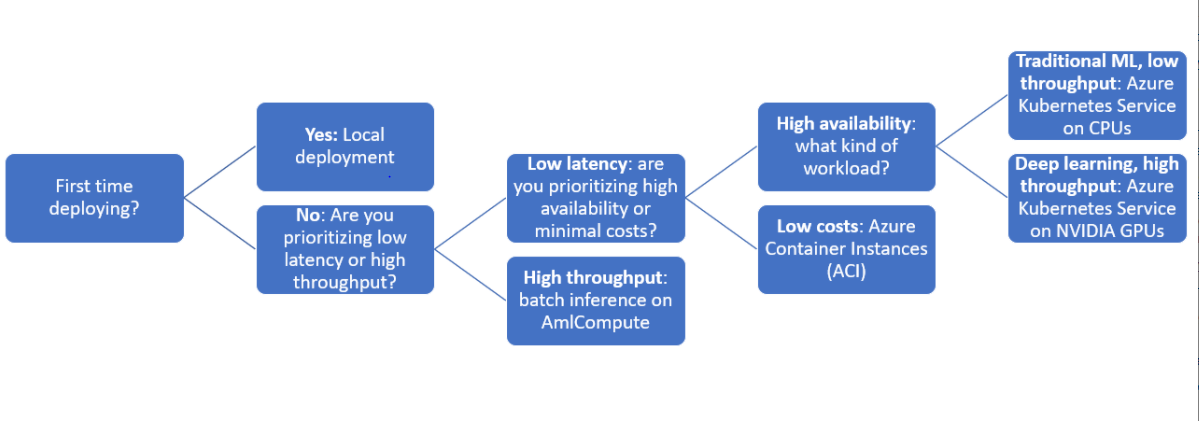

# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-and-where?tabs=python

In [16]:
from azureml.core.webservice import AciWebservice
aciconfig=AciWebservice.deploy_configuration(cpu_cores=1,memory_gb=1)

### Deployment config is talk about the mount of memory and cores to reserve for your webservice will require 
##in order to run, as well as configuration details of the underlying webservice.

In [17]:
## Deploy the Models
model=Model(ws,'diabeticmodeldemo')

In [18]:
deploy_infer= Model.deploy(ws,"scorepredicationdemo", models =[model], inference_config=InferenceConfig,
                           deployment_config=aciconfig, deployment_target=predenv)

In [22]:
 #### Scoring the model
import pandas as pd
import json
data =pd.read_csv("test.csv")
xt=data.values.tolist()
test=json.dumps({"data": xt})

In [23]:
test

'{"data": [[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0], [1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0], [8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0], [1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0], [0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0], [5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0], [3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0], [10.0, 115.0, 0.0, 0.0, 0.0, 35.3, 0.134, 29.0], [2.0, 197.0, 70.0, 45.0, 543.0, 30.5, 0.158, 53.0], [8.0, 125.0, 96.0, 0.0, 0.0, 0.0, 0.232, 54.0], [4.0, 110.0, 92.0, 0.0, 0.0, 37.6, 0.191, 30.0], [10.0, 168.0, 74.0, 0.0, 0.0, 38.0, 0.537, 34.0], [10.0, 139.0, 80.0, 0.0, 0.0, 27.1, 1.441, 57.0], [1.0, 189.0, 60.0, 23.0, 846.0, 30.1, 0.398, 59.0], [5.0, 166.0, 72.0, 19.0, 175.0, 25.8, 0.587, 51.0], [7.0, 100.0, 0.0, 0.0, 0.0, 30.0, 0.484, 32.0], [0.0, 118.0, 84.0, 47.0, 230.0, 45.8, 0.551, 31.0], [7.0, 107.0, 74.0, 0.0, 0.0, 29.6, 0.254, 31.0], [1.0, 103.0, 30.0, 38.0, 83.0, 43.3, 0.183, 33.0], [1.0, 115.0, 70.0, 30.0, 96.0, 34.6, 0

In [24]:
## Real time scoring
from azureml.core import Webservice
service=Webservice(workspace=ws,name='scorepredicationdemo')
print(service.scoring_uri)
print(service.swagger_uri)
y_hat=service.run(input_data= test)
y_hat

http://17316c6a-5dfb-44ac-a398-bdba73c9ecd7.eastus2.azurecontainer.io/score
http://17316c6a-5dfb-44ac-a398-bdba73c9ecd7.eastus2.azurecontainer.io/swagger.json


[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,


In [29]:
## Real Time Scoring using Rest
import requests
headers={'Content-Type':'application/json'}
# make the request and display the response
resp =requests.post(service.scoring_uri, test,headers=headers)
resp.text

'[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,

In [25]:
print(service.scoring_uri)


http://17316c6a-5dfb-44ac-a398-bdba73c9ecd7.eastus2.azurecontainer.io/score


In [43]:
#!curl -X POST \
 #  -H 'Content-Type': 'application/json'\
 #  -d '{"data": [[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0]]}'
     #http://17316c6a-5dfb-44ac-a398-bdba73c9ecd7.eastus2.azurecontainer.io/score
 #   
  

In [44]:
 #### Scoring the model
import pandas as pd
import json
data =pd.read_csv("test.csv")
#xt=data.values.tolist()
#test=json.dumps({"data": xt})

In [45]:
data.head()

,preg_count,glucose_concentration,diastolic_bp,triceps_skin_fold_thickness,two_hr_serum_insulin,bmi,diabetes_pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [46]:
xt=data.values.tolist()

In [48]:
test=json.dumps({"data": xt})

In [49]:
test

'{"data": [[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0], [1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0], [8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0], [1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0], [0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0], [5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0], [3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0], [10.0, 115.0, 0.0, 0.0, 0.0, 35.3, 0.134, 29.0], [2.0, 197.0, 70.0, 45.0, 543.0, 30.5, 0.158, 53.0], [8.0, 125.0, 96.0, 0.0, 0.0, 0.0, 0.232, 54.0], [4.0, 110.0, 92.0, 0.0, 0.0, 37.6, 0.191, 30.0], [10.0, 168.0, 74.0, 0.0, 0.0, 38.0, 0.537, 34.0], [10.0, 139.0, 80.0, 0.0, 0.0, 27.1, 1.441, 57.0], [1.0, 189.0, 60.0, 23.0, 846.0, 30.1, 0.398, 59.0], [5.0, 166.0, 72.0, 19.0, 175.0, 25.8, 0.587, 51.0], [7.0, 100.0, 0.0, 0.0, 0.0, 30.0, 0.484, 32.0], [0.0, 118.0, 84.0, 47.0, 230.0, 45.8, 0.551, 31.0], [7.0, 107.0, 74.0, 0.0, 0.0, 29.6, 0.254, 31.0], [1.0, 103.0, 30.0, 38.0, 83.0, 43.3, 0.183, 33.0], [1.0, 115.0, 70.0, 30.0, 96.0, 34.6, 0

# Create the Azure ML Pipelines

Using Pipelines you can use different hardware/compute for training and for data preparation purpose

let create two different clusted for Data Preparation & Training

In [17]:
######### Create Compute resources
from azureml.core.compute_target import ComputeTargetException

try:
    clusterprep = ComputeTarget(ws, 'demo-clusterprep')
except:
#cluster=ComputeTarget(ws,'demo-cluster')

    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2',
                                                              min_nodes=0,max_nodes=1, idle_seconds_before_scaledown=2400)
    clusterpre = ComputeTarget.create(ws, 'demo-clusterprep', compute_config)

In [18]:
try:
    clustertrain = ComputeTarget(ws, 'democlustertrain')
except:
#cluster=ComputeTarget(ws,'demo-cluster')

    configtrain = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2',
                                                              min_nodes=0,max_nodes=2, idle_seconds_before_scaledown=2400)
    clustertrain = ComputeTarget.create(ws, 'democlustertrain', configtrain)

In [19]:
# library to create a pipelines
from azureml.pipeline.core import Pipeline  # do all the data prep and other steps using Pipelines
from azureml.pipeline.steps import PythonScriptStep  # to run the training 
from azureml.core.runconfig import RunConfiguration ## to create the environment
from azureml.pipeline.core import PipelineData  # how we will pass the data 

In [31]:
## assign the training cluster to the runcconfig
aml_run_config=RunConfiguration()
aml_run_config.target= clustertrain
exp=Experiment(ws,"pipeline-demo")
envtrain=Environment.from_conda_specification(name="dsenv", file_path="./newenv.yml")
aml_run_config.environment=envtrain

In [32]:
##Pipelinedata 
def_ds=ws.get_default_datastore()
pipedata=PipelineData("pipelinedatademo", datastore=def_ds)

In [37]:
pipeflow1=PythonScriptStep(script_name='datapreppipe.py', name="data-preparation1", compute_target=clusterpre,
                          arguments=["--datastoarge", pipedata], outputs=[pipedata])

In [38]:
pipeflow2=PythonScriptStep(script_name='trainflowpipe.py', name="trainmodel11", compute_target=clustertrain, 
                           runconfig=aml_run_config,
                          arguments=["--in_folder", pipedata],inputs=[pipedata])

In [39]:
pipeflow=Pipeline(ws,steps=[pipeflow1,pipeflow2])

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [40]:
pipeexe= exp.submit(pipeflow)

Created step data-preparation1 [bd4aeff1][3fa62870-b1bf-4f14-93be-7b43c2758cd0], (This step will run and generate new outputs)Created step trainmodel11 [9a9b9ebc][9c878e50-1892-47c5-8527-b9bd5a48486c], (This step will run and generate new outputs)

Submitted PipelineRun be4e08c5-9645-4723-8f38-b5bf6025e24c
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/be4e08c5-9645-4723-8f38-b5bf6025e24c?wsid=/subscriptions/3b69f813-a314-415b-8861-e2a6a587ee02/resourcegroups/sukhiresourcegroup/workspaces/sukhiworkspace&tid=3b987e6b-eb5c-4ffc-a528-205ef2f9bdf7


In [ ]:
 ## Pipeline Scheduling
    
from azureml.pipeline.core import ScheduleRecurrence, Schedule

daily= ScheduleRecurrence(frequency='Day', interval=1)
pieline_schdeule=Schedule.create(ws, name='Daily Training', description='trains model every day',
                                 pipeline_id=published_pipeline.id, experinment_name='Training_Pipeline',
                                recurrence=daily)

# Deploy the Model using the AKS Cluster

In [41]:
##https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service?tabs=python

In [ ]:
from azureml.core.compute import AksCompute, ComputeTarget

   # Uses the specific FPGA enabled VM (sku: Standard_PB6s)
   # Standard_PB6s are available in: eastus, westus2, westeurope, southeastasia
prov_config = AksCompute.provisioning_configuration(vm_size = "standard_ds13-2_v2",
                                                    agent_count = 1,
                                                     location = "eastus")

aks_name = 'my-aks-pb6'
   # Create the cluster
aks_target = ComputeTarget.create(workspace = ws,
                                     name = aks_name,
                                     provisioning_configuration = prov_config)

In [ ]:
## Deploy the Models
model=Model(ws,'diabeticmodeldemo')

In [ ]:
from azureml.core.webservice import AksWebservice, Webservice
from azureml.core.model import Model

aks_target = AksCompute(ws,"my-aks-pb6")
# If deploying to a cluster configured for dev/test, ensure that it was created with enough
# cores and memory to handle this deployment configuration. Note that memory is also used by
# things such as dependencies and AML components.
deployment_config = AksWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)
service = Model.deploy(ws, "myservice", models =[model], inference_config, deployment_config, aks_target)
service.wait_for_deployment(show_output = True)
print(service.state)
print(service.get_logs())